In [1]:
import pandas as pd
import prepare

import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

# Set alpha significance level to 0.05
alpha = 0.05

# Superstore Time Series Project: Where should we go with our product strategy?

### The goal of this project was to come up with recommendations for the VP of Product related to the following questions:
- Which product line should we expand?
- Is there a product category that is particularly profitable?
- What product category is least profitable, why?
- Does one or anther stand out in terms of sales volume?
- How do these relationships change if we control for customer segment?


## Acquiring and preparing the data from the superstore_db:
- The data for this project is from a SQL Database called 'superstore_db' located on a cloud server. The acquire.py script is used to query the database for the required data tables and returns the data in a Pandas DataFrame. This script also saves a local cached DataFrame to a 'superstore.csv' file for faster subsequent loads. 

- The prepare.py module has the prepare_superstore_data function:
    - Renaming the original columns to a consistent lowercase names
    - strip spaces from column names and instead separate names with '_' character
    - drop unnecessary columns  with suffix ..'id'
    - index the order date columns to pandas datetime and reset index on the same order date column. 
    - Filled null with 0. 

In [2]:
df = prepare.prepare_superstore_data()

Reading csv file..


In [3]:
df.shape

(1734, 20)

In [4]:
# No null values in the acquired and prepared data
df.isnull().sum().sum()

0

#### Note: No data splitting performed for this exploration as modeling not planned initially. Future work may involved creating a forecasting model in which case the data would be split into train, validate, and test sets.

## Exploration

### Data contains sales and profit information for 3 categories of products

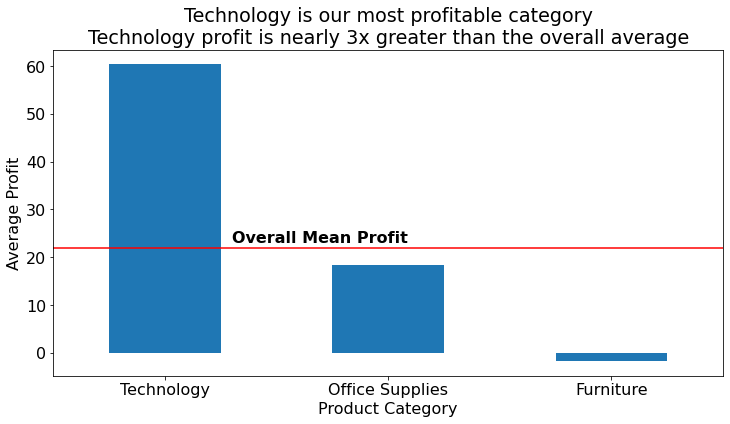

In [5]:
# Group by category to see average profit
df.groupby("category").profit.mean().sort_values(ascending=False).plot.bar()
plt.title('Technology is our most profitable category\nTechnology profit is nearly 3x greater than the overall average')
plt.axhline(df.profit.mean(), color = 'r')
plt.annotate('Overall Mean Profit', xy=(0.3,23), fontweight='bold')
plt.xticks(rotation=0)
plt.xlabel("Product Category")
plt.ylabel("Average Profit")
plt.show()

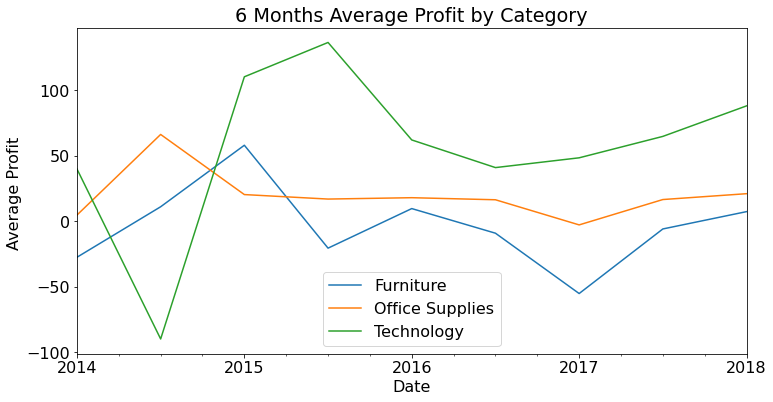

In [6]:
# Profit of categories over time , resampled at 6 months
for cat in df.category.unique():
    sample = df[df.category == cat]
    sample.resample('6M').profit.mean().plot(label = cat)
    plt.title('6 Months Average Profit by Category')
    plt.ylabel('Average Profit ')
    plt.xlabel('Date')
    plt.legend()
# plt.axhline(df.profit.mean(), color='r')


In [7]:
# Perform t-test statistical testing of average profit by category
for cat in df["category"].unique():
    overall_mean = df.profit.mean()
    print(overall_mean)
    sample = df[df["category"] == cat].profit
    t,p = stats.ttest_1samp(sample, overall_mean)
    print(cat, "samples: ",len(sample), "t:", round(t,2), "p", round(p,4), "cat mean",round(sample.mean(),2))
    if (t>0)&(p/2<alpha):
        print("Significant Higher ", cat)
    if (t<0)&(p/2<alpha):
        print("Significant Lower ", cat)

21.88035138408307
Furniture samples:  360 t: -2.74 p 0.0065 cat mean -1.73
Significant Lower  Furniture
21.88035138408307
Office Supplies samples:  1055 t: -0.82 p 0.4133 cat mean 18.31
21.88035138408307
Technology samples:  319 t: 1.94 p 0.0531 cat mean 60.35
Significant Higher  Technology


### Technology is significantly more profitable than the overall average and is the only category more profitable than average

### Taking a look at subcategories

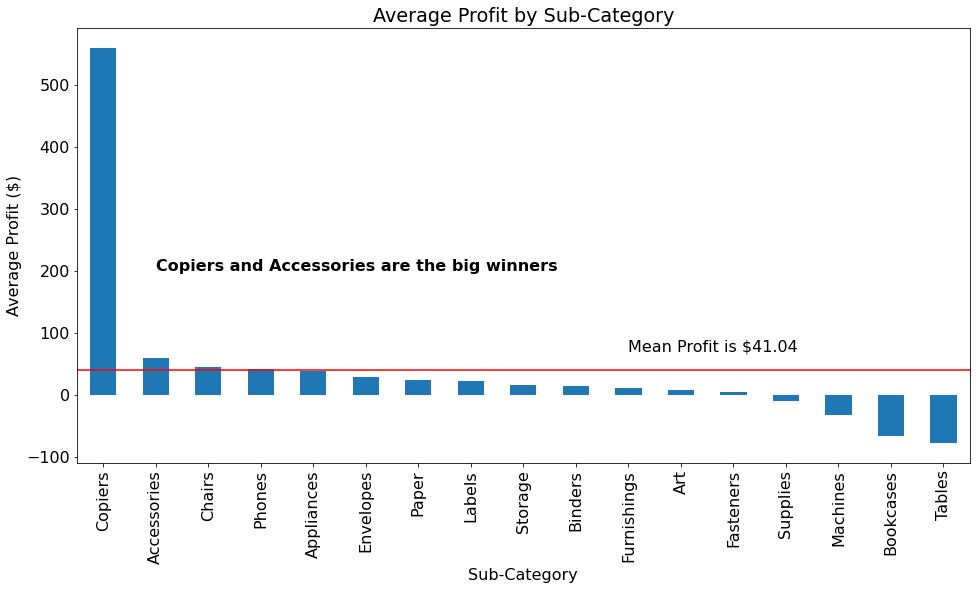

In [8]:
# Plot the subcategory average profit over the whole data set
mean_profit = df.groupby("sub_category").profit.mean().mean()
plt.figure(figsize=(16,8))
df.groupby("sub_category").profit.mean().sort_values(ascending=False).plot.bar()
plt.title(f'Average Profit by Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Average Profit ($)')
plt.axhline(mean_profit, color='r')
plt.annotate('Copiers and Accessories are the big winners', xy=(1,200), fontweight='bold')
plt.annotate(f'Mean Profit is ${mean_profit:.2f}', xy=(10,70))
None

In [9]:
# Perform ttest of sub category mean profit, alpha 0.05
for sub in df["sub_category"].unique():
    overall_mean = df.profit.mean()
    # print(overall_mean)
    sample = df[df["sub_category"] == sub].profit
    t,p = stats.ttest_1samp(sample, overall_mean)
    if (t>0)&(p/2<alpha):
        print(sub, "samples: ",len(sample), "t:", round(t,2), "p", round(p,4), "cat mean",round(sample.mean(),2))
        print("Significant Higher ", sub)
    if (t<0)&(p/2<alpha):
        print(sub, "samples: ",len(sample), "t:", round(t,2), "p", round(p,4), "cat mean",round(sample.mean(),2))
        print("Significant Lower ", sub)

Chairs samples:  95 t: 1.78 p 0.0784 cat mean 45.33
Significant Higher  Chairs
Tables samples:  62 t: -3.4 p 0.0012 cat mean -77.2
Significant Lower  Tables
Furnishings samples:  168 t: -2.22 p 0.0281 cat mean 12.64
Significant Lower  Furnishings
Accessories samples:  131 t: 3.17 p 0.0019 cat mean 59.44
Significant Higher  Accessories
Phones samples:  157 t: 2.72 p 0.0073 cat mean 41.7
Significant Higher  Phones
Art samples:  149 t: -9.37 p 0.0 cat mean 8.97
Significant Lower  Art
Supplies samples:  28 t: -3.31 p 0.0026 cat mean -9.07
Significant Lower  Supplies
Fasteners samples:  43 t: -21.42 p 0.0 cat mean 5.02
Significant Lower  Fasteners
Copiers samples:  10 t: 3.47 p 0.0071 cat mean 559.84
Significant Higher  Copiers


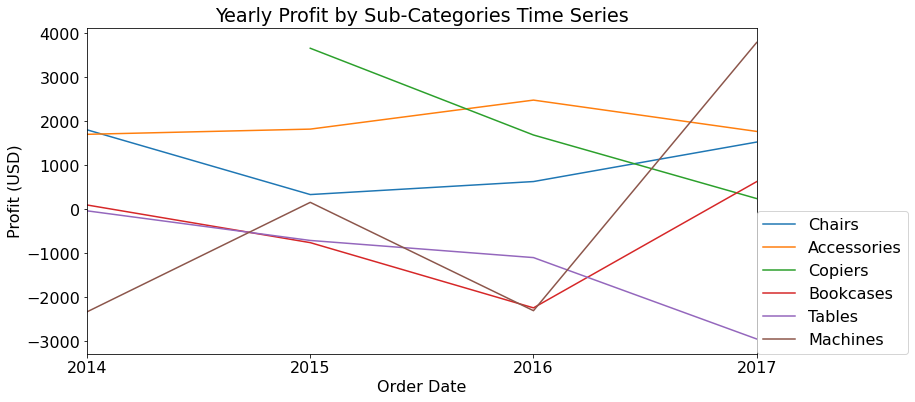

In [20]:
# Profit of categories over time 
# Sub df with profitable sub-categories 
profitable_sub_cat = df[(df.sub_category == 'Chairs') |(df.sub_category == 'Copiers') |(df.sub_category == 'Accessories')]
least_profitable_sub_cat = df[(df.sub_category == 'Machines') |(df.sub_category == 'Bookcases') |(df.sub_category == 'Tables')]

# Sub-category profit every 6 months - too many subcategories to plot them all so restricted to bottom and top 3
# plt of the 3 most profitable sub categories
for cat in profitable_sub_cat.sub_category.unique():
    sample = profitable_sub_cat[profitable_sub_cat.sub_category == cat]
    sample.resample('y').profit.sum().plot(label = cat)
    plt.ylabel('Profit (USD)')
    plt.xlabel('Order Date')
    plt.legend(loc = (1.0, 0.0))
# plot of the 3 least profitable sub categories
for cat in least_profitable_sub_cat.sub_category.unique():
    sample = least_profitable_sub_cat[least_profitable_sub_cat.sub_category == cat]
    sample.resample('y').profit.sum().plot(label = cat)
    plt.title('Yearly Profit by Sub-Categories Time Series')
    plt.ylabel('Profit (USD)')
    plt.xlabel('Order Date')
    plt.legend(loc = (1.0, 0.0))
# Mean profit line - not necessary
# plt.axhline(df.profit.mean(), color='r')
None


### Copiers and accessories, both members of the technology category, show significantly greater profitability than the overall average

### Over the years however copiers appear to be declining in profit, while machines are increasing. This explains why technology is still increasing.

### To help focus our marketing efforts - do any customer segments show greater profitability by category?

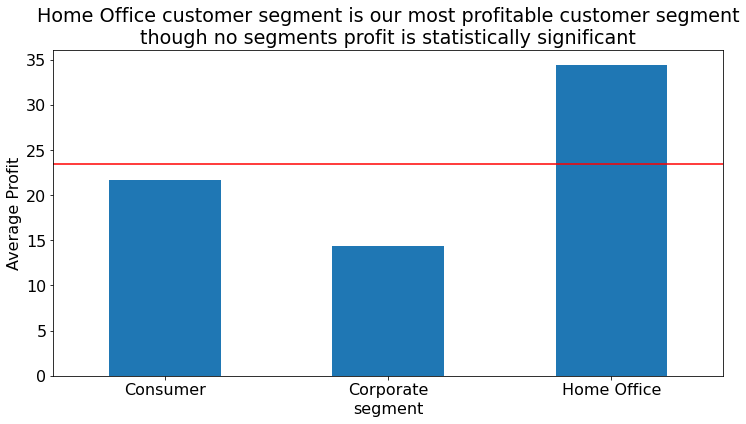

In [22]:
# Group by segment to see average profit
df.groupby("segment").profit.mean().plot.bar()
plt.title('Home Office customer segment is our most profitable customer segment\nthough no segments profit is statistically significant')
plt.axhline(df.groupby("segment").profit.mean().mean(), color='r')
plt.ylabel("Average Profit")
plt.xticks(rotation=0)
None

In [12]:
# Perform a statistical test using t-test of segments
for seg in df["segment"].unique():
    overall_mean = df.profit.mean()
    sample = df[df["segment"] == seg].profit
    t,p = stats.ttest_1samp(sample, overall_mean)
    print(seg, t, p)
    if (t>0)&(p/2<alpha):
        print("Significantly Higher ", seg)
    if (t<0)&(p/2<alpha):
        print("Significantly Lower ", seg)

Consumer -0.03445293621343272 0.9725231861326742
Corporate -0.7047901450011024 0.48128481804380385
Home Office 1.10146674811096 0.2715735655988104


### No customer segments have statistically significant average profit greater or less than the overall mean

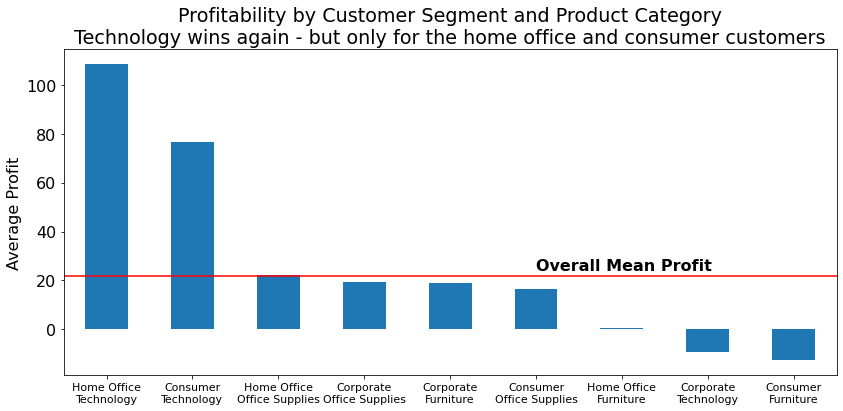

In [13]:
profit_by_seg_cat = df.groupby(["segment","category"]).profit.mean().sort_values(ascending=False)
# Grab the xtick labels
l=profit_by_seg_cat.index.tolist()
# Original index values are multiindex, not great for plotting. This adds a new line between segment and category
xlabs=[i[0]+"\n"+i[1] for i in l]
# Plot a bar chart
ax1=profit_by_seg_cat.plot.bar()
plt.axhline(df.profit.mean(), color = 'r')
plt.annotate('Overall Mean Profit', xy=(5,24), fontweight='bold')
ax1.set_xticklabels(xlabs)
plt.title("Profitability by Customer Segment and Product Category\nTechnology wins again - but only for the home office and consumer customers")
plt.xlabel("")
plt.xticks(fontsize=11, rotation = 0)
plt.ylabel("Average Profit")
plt.tight_layout()
plt.show()

In [14]:
# Perform statistical analysis using t test or wilcoxon sign rank depending on sample size. Alpha is 0.05
overall_mean_profit = df.profit.mean()
for seg in df["segment"].unique():
    for cat in df.category.unique():
        sample = df[(df.segment == seg)&(df.category == cat)].profit
        if len(sample) >30:
            t,p = stats.ttest_1samp(sample, overall_mean_profit)
            used = 'ttest'
        else:
            t,p = stats.wilcoxon(sample)
            used = 'wilcoxon'
        if (t>0)&(p/2<alpha):
            print("Significantly Higher ", seg, cat, used)
        if (t<0)&(p/2<alpha):
            print("Significantly Lower ", seg, cat, used)

Significantly Lower  Consumer Furniture ttest
Significantly Higher  Consumer Technology ttest
Significantly Higher  Home Office Technology ttest


### Statistical testing confirms Home Office and Consumer customers with Technology product category is significantly more profitable than the overall average

### How do the categories compare in terms of sales volume (quantity)?

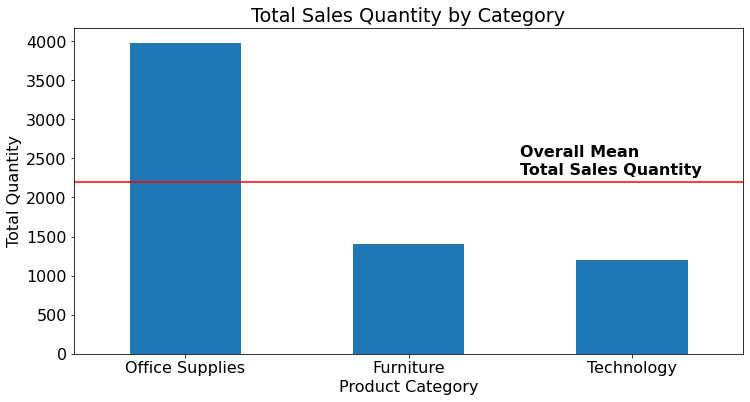

In [15]:
# Group by category to see total sales quantity
df.groupby("category").quantity.sum().sort_values(ascending=False).plot.bar()
plt.title('Total Sales Quantity by Category')
plt.axhline(df.groupby("category").quantity.sum().mean(), color = 'r')
plt.annotate('Overall Mean \nTotal Sales Quantity', xy=(1.5,2300), fontweight='bold')
plt.xticks(rotation=0)
plt.xlabel("Product Category")
plt.ylabel("Total Quantity")
plt.show()

### We do the least volume in Technology, but this is our most profitable category!

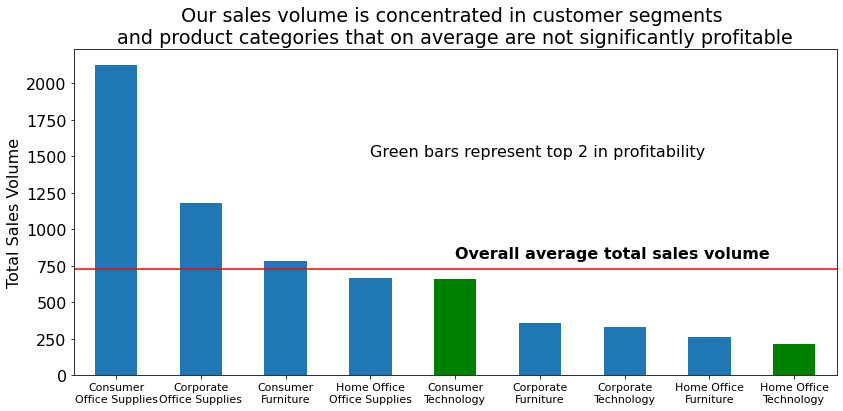

In [16]:
profit_by_seg_cat = df.groupby(["segment","category"]).profit.mean().sort_values(ascending=False)

qty_by_seg_cat = df.groupby(["segment","category"]).quantity.sum().sort_values(ascending=False)
# Grab the xtick labels
l=qty_by_seg_cat.index.tolist()
# Original index values are multiindex, not great for plotting. This adds a new line between segment and category
xlabs=[i[0]+"\n"+i[1] for i in l]
# Colors bars based on if they are in the top 4 profitable segment/category combo
clrs=['green' if (x in profit_by_seg_cat.head(2).index) else '#1f77b4' for x in df.groupby(["segment","category"]).quantity.sum().sort_values(ascending=False).index]

# plot bar chart of total quantity by segment and category
ax1=df.groupby(["segment","category"]).quantity.sum().sort_values(ascending=False).plot.bar(color=clrs)

plt.axhline(df.groupby(["segment","category"]).quantity.sum().mean(), color = 'r')
plt.title("Our sales volume is concentrated in customer segments \nand product categories that on average are not significantly profitable")
plt.annotate("Green bars represent top 2 in profitability", xy=(3, 1500))
plt.annotate("Overall average total sales volume",xy=(4,800), fontweight='bold')
ax1.set_xticklabels(xlabs)
plt.xlabel("")
plt.ylabel("Total Sales Volume")
plt.xticks(fontsize=11, rotation = 0)
plt.tight_layout()
plt.show()

### While sales volume is not the greatest metric to go off considering you buy many more stacks of paper than tables, this shows we concentrate most of our sales in areas that aren't so profitable.

## Examing profit/quantity

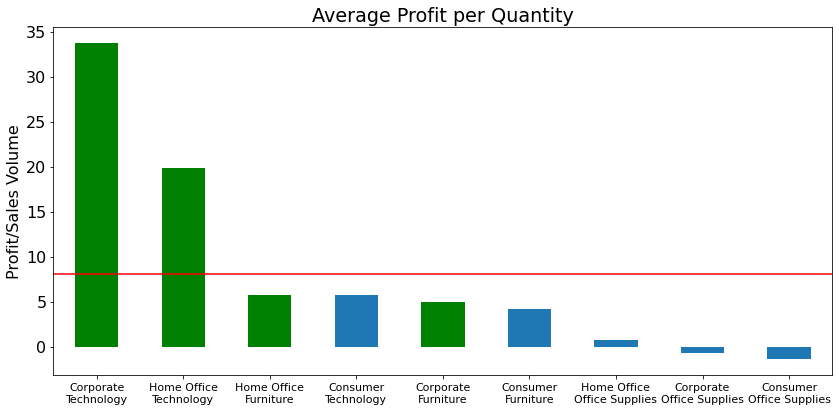

In [26]:
# Create additional column
df["profit_over_quantity"] = df.profit/df.quantity
df["sales_over_quantity"] = df.sales/df.quantity


# Group by segment and category for profit
profit_by_seg_cat = df.groupby(["segment","category"]).profit.mean().sort_values(ascending=False)
# Group by segment and category for profit over quantity
pro_qty_by_seg_cat = df.groupby(["segment","category"]).profit_over_quantity.mean().sort_values(ascending=False)
# Group by segment and category for sales over quantity
pro_qty_by_seg_cat = df.groupby(["segment","category"]).sales_over_quantity.mean().sort_values(ascending=False)


# Grab the xtick labels
l=pro_qty_by_seg_cat.index.tolist()
# Original index values are multiindex, not great for plotting. This adds a new line between segment and category
xlabs=[i[0]+"\n"+i[1] for i in l]
# Colors bars based on if they are in the top 4 profitable segment/category combo
clrs=['green' if (x in profit_by_seg_cat.head(4).index) else '#1f77b4' for x in df.groupby(["segment","category"]).profit_over_quantity.mean().sort_values(ascending=False).index]
# plot bar chart
ax1=df.groupby(["segment","category"]).profit_over_quantity.mean().sort_values(ascending=False).plot.bar(color=clrs)

plt.axhline(df.groupby(["segment","category"]).profit_over_quantity.mean().mean(), color = 'r')
plt.title("Average Profit per Quantity")
plt.annotate("Green bars represent top 4 in profitability", xy=(3, 1500))
plt.annotate("Overall average total sales volume",xy=(4,800), fontweight='bold')
ax1.set_xticklabels(xlabs)
plt.xlabel("")
plt.ylabel("Profit/Sales Volume")
plt.xticks(fontsize=11, rotation = 0)
plt.tight_layout()
plt.show()

## How do the different Discounts affect the Product profits?

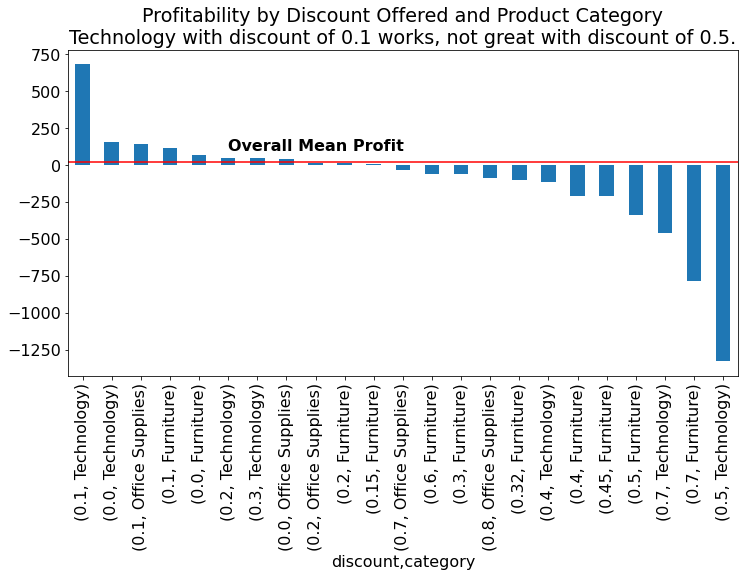

In [18]:
profit_by_disc_cat = df.groupby(["discount","category"]).profit.mean().sort_values(ascending=False)
profit_by_disc_cat.plot.bar()
plt.axhline(df.profit.mean(), color = 'r')
plt.annotate('Overall Mean Profit', xy=(5,100), fontweight='bold')
plt.title("Profitability by Discount Offered and Product Category\nTechnology with discount of 0.1 works, not great with discount of 0.5.")
plt.show()

### Technology even though its performing well overall, factoring in discounts offered, it under-performs with 0.5 discount.
- Best discount:
    - Technology = 0.1
    - Furniture = 0.1
    - Supplies = 0.0 (offer no discount at the moment)
- Overall discount obvervation, the higher the discount, the least profitable the product category is.


# Key Findings from Exploration 

- Technology product category is the most profitable. 
- Least profitable category is the furniture(making loses).
- Most profitable sub-categories are copiers, Accessories, and Chairs and least profitable (incurring loss) being Machines, Bookcases, and Tables.
- Home office and consumer segments with combination with Technology are very profitable.
- High sales volume does not equate to higher profits.

# Conclusion

- We should improve our technology offerings as this is our most profitable product category
- Concentrate on most profitable customer segments and product category, notably:
       - Technology: Home Office and Consumer (average profit is > 3 x overall average)
- Re-evaluate furniture sales as this is our least profitable product category (average loss in this category) despite having one of the highest sales volumes.

# Future work

- Evaluate products sold by region and how they vary
- Evaluate discount and ship date and how these factors affect profit 
- Create model that can predict future frofits accurately 